In [3]:
%load_ext autoreload
%autoreload 2
from util import *
from ArcExpression import get_Arc_expression, normalize_Arc, normalize_IEG

from scipy import stats
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
proj_meta = load_meta()

### Normalization within-timepoint

Text(0.5,1,'Arc distribution by timepoint')

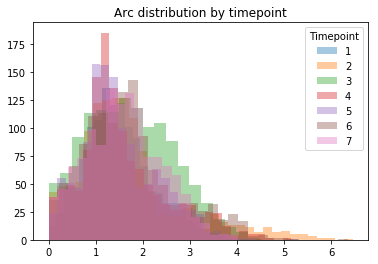

In [7]:
figsize = (16,12)
tps = np.int32(np.linspace(0, 12, 7))
ieg_levs = {}
cnt = 0
ieg_inds = [range(4), range(4,9)]
for cond in range(len(tps)):
    arc_levs = []
    arc_levs.append(
            [normalize_IEG(get_Arc_expression(proj_meta, site, tps[cond]))
            for site in range(4)])
    
#     ieg_levs[cnt] = np.hstack(np.hstack(np.mean(arc_levs, axis=1)))
    ieg_levs[cnt] = np.hstack(np.hstack(arc_levs))

    sns.distplot(ieg_levs[cnt], label="{}".format(cond+1), kde=False)
    cnt += 1

plt.legend(title="Timepoint");
plt.title("Arc distribution by timepoint")

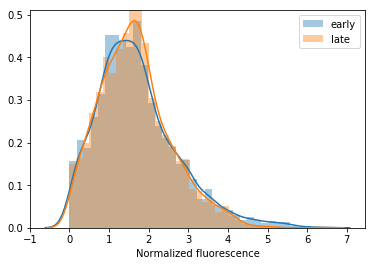

In [9]:
tmp_early = np.hstack((ieg_levs[1], ieg_levs[2]))
tmp_late = np.hstack((ieg_levs[5], ieg_levs[6]))
sns.distplot(tmp_early, label="early")
sns.distplot(tmp_late, label="late")
plt.legend()
plt.xlabel("Normalized fluorescence");

### Normalization across timepoints

In [37]:
ieg_ranges = (range(4), range(4,9))

tps = np.int32(np.linspace(0, 12, 7)) # IEG Timepoints

tp_tested = 13 # Timepoint where tone activity is interrogated

cum_ieg = []
for site in range(9):
    cum_ieg.append([np.mean(get_Arc_expression(proj_meta, site, tp),
                 axis=1) for tp in tps])

## Normalize

arc = np.hstack(cum_ieg[:4])
arc_sub = arc - np.min(arc)
arc_norm = arc_sub/np.median(arc_sub)

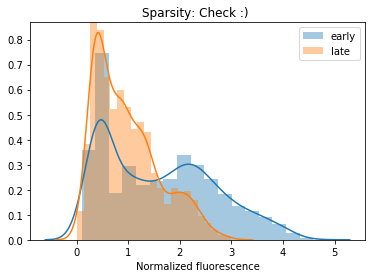

In [58]:
# Split into early and late, as before
tmp_early = np.hstack((arc_norm[1,:], arc_norm[2,:]))
tmp_late = np.hstack((arc_norm[5,:], arc_norm[6,:]))
sns.distplot(tmp_early, label="early")
sns.distplot(tmp_late, label="late")
plt.legend()
plt.xlabel("Normalized fluorescence");
plt.title("Sparsity: Check :) ");

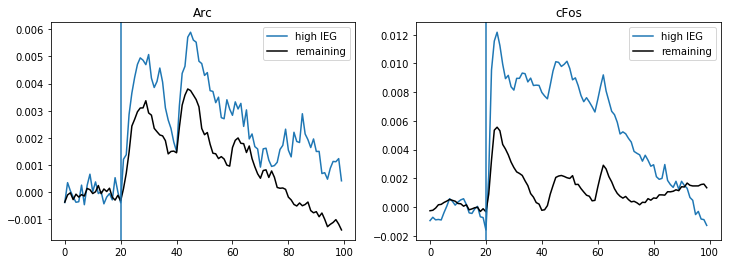

In [150]:
ieg_ranges = (range(4), range(4,9))
plt.figure(figsize=(12,4))
titles = ["Arc", "cFos"]
tps = np.int32(np.linspace(0, 12, 7)) # IEG Timepoints

tp_tested = 13 # Timepoint where tone activity is interrogated

for ieg_ind in range(2):
    mn_ieg = []
    mn_act = []
    plt.subplot(1,2,ieg_ind+1)
    for site in ieg_ranges[ieg_ind]:
        cum_arc = np.vstack([np.mean(
            get_Arc_expression(proj_meta, site, tp),
                      axis=1) for tp in tps])

        # get tone responses
        tone_act = np.hstack(tone_responses(proj_meta, site, tp=tp_tested,
                                            win_pre=20, win_post=80))
        # mean-subtract
        tone_act = elemwise_subtract(tone_act, np.mean(tone_act[:,:,10:19], axis=2))

        # Decide how to select high arc cells
        mn_ieg.append(np.mean(cum_arc[1:2,:], axis=0))
        
        mn_act.append(np.mean(tone_act, axis=1))
    
    mn_ieg = np.hstack(mn_ieg)
    mn_act = np.vstack(mn_act)
    arc = (mn_ieg)
    arc_sub = arc - np.min(arc)
    mn_ieg = arc_sub/np.median(arc_sub)
    # Get cells at certain percentile of IEG expression
    IEG_cells = np.where(mn_ieg >= np.percentile(mn_ieg, 90))[0]
    rem_cells = np.setdiff1d(np.arange(mn_act.shape[0]), IEG_cells)

    ieg_act = mn_act[IEG_cells,:]
    rem_act = mn_act[rem_cells,:]

    plt.plot(np.mean(ieg_act,axis=0), label="high IEG")
    plt.plot(np.mean(rem_act,axis=0),color="k", label="remaining")
    plt.axvline(20)
    plt.legend()
    plt.title(titles[ieg_ind])

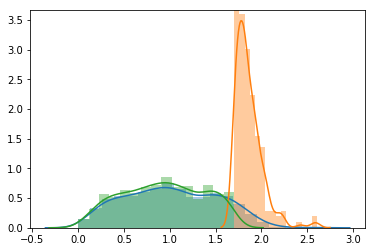

In [79]:
sns.distplot(mn_ieg)
sns.distplot(mn_ieg[IEG_cells])
sns.distplot(mn_ieg[rem_cells])

In [145]:
ieg_ranges = (range(4), range(4,9))
# plt.figure(figsize=(12,4))
titles = ["Arc", "cFos"]
tps = np.int32(np.linspace(0, 12, 7)) # IEG Timepoints

tp_tested = 13 # Timepoint where tone activity is interrogated

pct_range = range(1, 100, 2) # increasing range of percentiles to check

IEG_hi = []
IEG_lo = []
for ieg_ind in range(2):
    mn_ieg = []
    mn_act = []
#     plt.subplot(1,2,ieg_ind+1)
    for site in ieg_ranges[ieg_ind]:
        cum_arc = np.vstack([np.mean(
            get_Arc_expression(proj_meta, site, tp)
                     , axis=1) for tp in tps])
        # get tone responses
        tone_act = np.hstack(tone_responses(proj_meta, site, tp=tp_tested,
                                            win_pre=20, win_post=80))
        # mean-subtract
        tone_act = elemwise_subtract(tone_act, np.mean(tone_act[:,:,10:19], axis=2))

        # Decide how to select high arc cells
        mn_ieg.append(np.median(cum_arc[1:2,:], axis=0))
        
        mn_act.append(np.mean(tone_act, axis=1))
    
    mn_ieg = np.hstack(mn_ieg)
    arc = (mn_ieg)
    arc_sub = arc - np.min(arc)
    mn_ieg = arc_sub/np.median(arc_sub)
    mn_act = np.vstack(mn_act)
    
    ieg_hi_act = []
    ieg_lo_act = []
    # Get cells at certain percentile of IEG expression
    for pctile in pct_range:
        IEG_cells = np.where(mn_ieg >= np.percentile(mn_ieg, pctile))[0]
        rem_cells = np.setdiff1d(np.arange(mn_act.shape[0]), IEG_cells)
 
        ieg_hi_act.append(np.mean(mn_act[IEG_cells,:], axis=0))
        ieg_lo_act.append(np.mean(mn_act[rem_cells,:], axis=0))
                
     
    IEG_hi.append(ieg_hi_act)
    IEG_lo.append(ieg_lo_act)
    ieg_act = mn_act[IEG_cells,:]
    rem_act = mn_act[rem_cells,:]

#     plt.plot(np.mean(ieg_act,axis=0), label="high IEG")
#     plt.plot(np.mean(rem_act,axis=0),color="k", label="remaining")
#     plt.axvline(20)
#     plt.legend()
#     plt.title(titles[ieg_ind])

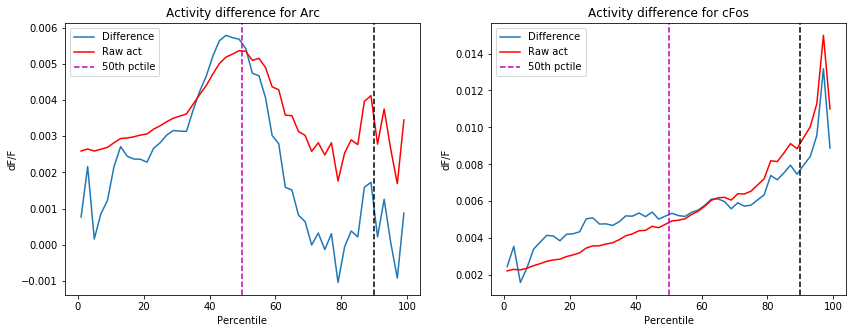

In [146]:
plt.figure(figsize=(14,5))
for ind in range(2):
    plt.subplot(1,2,ind+1)
    ieg_by_pct = np.mean(np.vstack(IEG_hi[ind])[:,30:55], axis=1)

    diff_by_pct = np.mean(np.vstack(IEG_hi[ind])[:,30:55], axis=1) -\
            np.mean(np.vstack(IEG_lo[ind])[:,30:55], axis=1)
        
    plt.plot(pct_range, diff_by_pct, label="Difference")
    plt.plot(pct_range, ieg_by_pct, color="r", label="Raw act")
    plt.title("Activity difference for {}".format(titles[ind]))
    plt.axvline(90, color="k", linestyle="--")
    plt.axvline(50, color="m", linestyle="--", label="50th pctile")
    plt.xlabel("Percentile")
    plt.ylabel("dF/F")
    plt.legend()

In [129]:
tmp = get_Arc_expression(proj_meta, 0, 6)

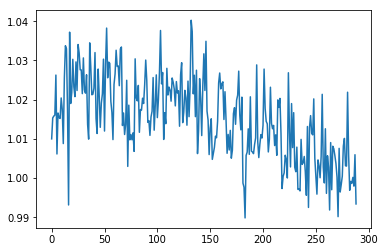

In [131]:
plt.plot(normalize_Arc(tmp));

In [124]:
tmp2 = (get_Arc_expression(proj_meta, 0, 6, by_z=True))

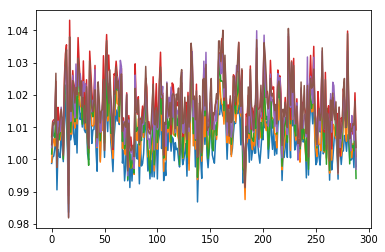

In [125]:
plt.plot(tmp2)

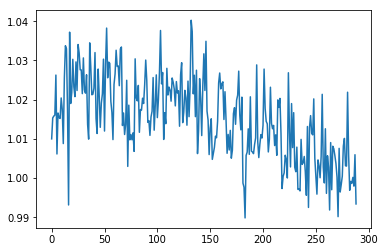

In [128]:
plt.plot(tmp/np.median(np.percentile(tmp, 8)))